In [1]:
#Necessary Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from matplotlib import cm as CM
from matplotlib import mlab as ML
import numpy as np

In [2]:
#import the data
data = pd.read_csv('2020-train.csv')

In [3]:
#checking that I filtered correctly
data.pitch_call.value_counts()

BallCalled         209705
FoulBall           102810
InPlay             102011
StrikeCalled        98111
StrikeSwinging      68000
HitByPitch           1546
BallIntentional        22
Name: pitch_call, dtype: int64

In [4]:
#Filter only frameable pitches
data = data.loc[(data['pitch_call'] == 'BallCalled') | (data['pitch_call'] == 'StrikeCalled')]

In [5]:
#I did filter correctly
data.pitch_call.value_counts()

BallCalled      209705
StrikeCalled     98111
Name: pitch_call, dtype: int64

Text(0.5, 1.0, 'Strike Zone')

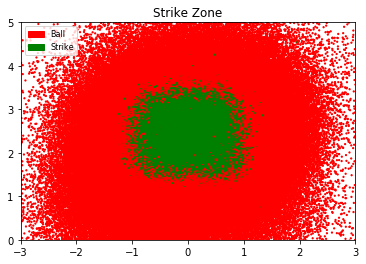

In [6]:
#Plot the pitches and color code by call
fMapping = {'BallCalled': 'red', 'StrikeCalled' : 'green'}
plt.scatter(data.plate_side, data.plate_height, c=list(data['pitch_call'].map(fMapping)), s=1.5)

#Create patches which can be imported to label the legend
Ball = mpatches.Patch(color='red', label='Ball')
Strike = mpatches.Patch(color='green',label='Strike')

#Use the patches to create a legend, add title, set limits
plt.xlim((-3,3))
plt.ylim((0,5))
plt.legend(handles=[Ball, Strike], prop={'size': 8})
plt.title("Strike Zone")

#Even though it is the same data as before, never bad to graph it.

In [7]:
sides = {'Right' : 0, 'Left': 1}

#Removed infinite value and replaced batter/pitcher sides with numerics for modelling
data = data.replace([np.inf, -np.inf], np.nan)

#map out the numerics for handedness
data.pitcher_side = list(data['pitcher_side'].map(sides))
data.batter_side = list(data['batter_side'].map(sides))

# Note, that I did not want to use inferred values for the coaches report.
# I thought that it would be better to use more certain data for this analysis since it would be used immediately
data = data.dropna()

In [8]:
#put all of the potentially relevant data points into a test and train series
X = data[['pitcher_side', 'batter_side', 'outs', 'balls', 'strikes',
       'release_speed', 'vert_release_angle', 'horz_release_angle',
       'spin_rate', 'spin_axis', 'rel_height', 'rel_side', 'extension',
       'vert_break', 'induced_vert_break', 'horz_break', 'plate_height',
       'plate_side', 'zone_speed', 'vert_approach_angle',
       'horz_approach_angle', 'zone_time', 'x55', 'z55']]
y = data.pitch_call

# Random state of 116 with a nod to 2001
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=116)

In [9]:
# load a random forest classifier to model the outcomes
# Note that the decision to use 20 estimators was somewhat arbitrary.
# It results in round 5 percentage intervals in the voting probabilities.
# Several levels of estimators were tested that did not significantly change the performance of the model.
# A more in-depth version of this analysis would have optimized the classifier model, including tree depth and n_estimators. 
rf = RandomForestClassifier(n_estimators = 20)

In [10]:
#fit the model to the training data
rf = rf.fit(X_train, y_train)
#display the scores in and out of sample
print(f'{round(rf.score(X_train, y_train),4)* 100} % in sample.')
print(f'{round(rf.score(X_test, y_test),4)*100} % out of sample.')

#Pretty strong results,should be useful enough to determine a probabalistic model for framing to deliver to coaches.

99.86 % in sample.
92.5 % out of sample.


In [11]:
#create a dummy dataframe for the probabilities for Strike/Ball Calls
df = pd.DataFrame(np.column_stack(list(zip(*rf.predict_proba(X)))), columns=list('AB'))

In [12]:
#Add the strike/Ball probabilities to the dataframe
data['Strike_Prob'] = list(df.B)
data['Ball_Prob'] = list(df.A)

In [13]:
data2 = data[data['Strike_Prob'] == .5]

Text(0.5, 1.0, 'Strike Zone 50/50 Calls')

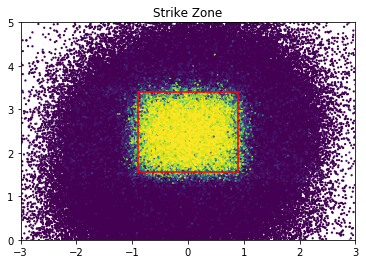

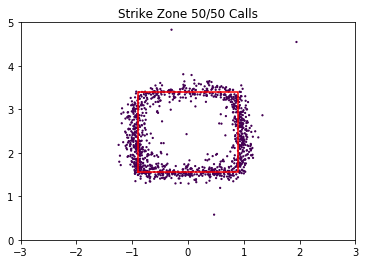

In [14]:
#Plot the pitches and color code by probability
plt.figure(0)
plt.scatter(data.plate_side, data.plate_height, c=list(data['Strike_Prob']), s=1.5)

#Use the patches to create a legend, add title, set limits
plt.xlim((-3,3))
plt.ylim((0,5))
plt.title("Strike Zone")

#Adding a rough outline of the strikezone helps identify visually where calls can be framed.
#This should also line up roughly with our 50/50 calls graph below
x=[-.9, -.9, .9, .9, -.9]
y=[1.55,  3.4, 3.4, 1.55, 1.55]
plt.plot(x,y, 'r-')

plt.figure(1)
plt.scatter(data2.plate_side, data2.plate_height, c=list(data2['Strike_Prob']), s=1.5)
plt.plot(x,y, 'r-')
plt.xlim((-3,3))
plt.ylim((0,5))
# plt.legend(handles=[Ball, Strike], prop={'size': 8})
plt.title("Strike Zone 50/50 Calls")
# Graphed the total zone and the 50/50 calls to see if it was a reaonable approximation of the zone.
# Seems pretty good!

In [15]:
# Isolate the data for our catcher
catcher = data[data.catcher_id == 'f06c9fdf']

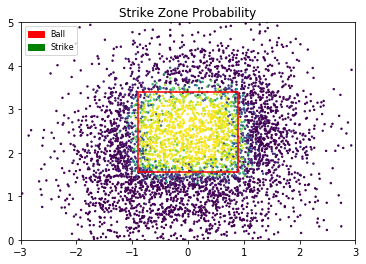

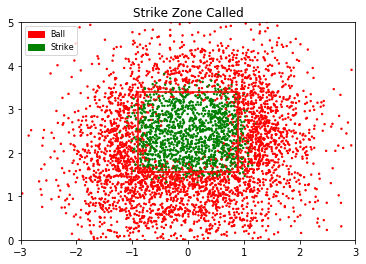

In [16]:
#Plotted his total pitches by probability
plt.figure(0)
plt.scatter(catcher.plate_side, catcher.plate_height, c=list(catcher['Strike_Prob']), s=2)

plt.xlim((-3,3))
plt.ylim((0,5))
plt.legend(handles=[Ball, Strike], prop={'size': 8})
plt.title("Strike Zone Probability")
plt.plot(x,y, 'r-')
#Plot the pitches and color code by call
plt.figure(1)
plt.scatter(catcher.plate_side, catcher.plate_height, c=list(catcher['pitch_call'].map(fMapping)), s=2)

#Use the patches to create a legend, add title, set limits
plt.xlim((-3,3))
plt.ylim((0,5))
plt.legend(handles=[Ball, Strike], prop={'size': 8})
plt.title("Strike Zone Called")
plt.plot(x,y, 'r-')
# Our catcher's estimated strike zone according to the model.
# Seems reasonable.

# Our catcher's actual called strike zone. Still interesting!
# But probably not detailed enough to be useful.

In [17]:
## In order to make it useful, we should remove all of the % calls.
## We should also highlight where he was significantly above or below average.
## Below we'll attempt that.

In [18]:
catcher2 = catcher[catcher.Strike_Prob < .95]
catcher2 = catcher2[catcher.Strike_Prob > .05]

C:\Users\Trevor\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


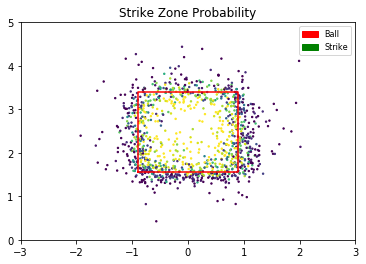

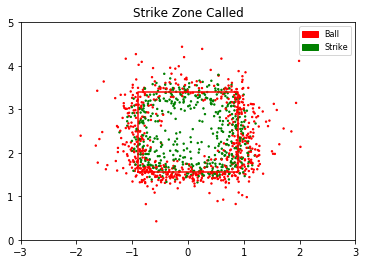

In [19]:
#Did the same plotting again!
plt.figure(0)
plt.scatter(catcher2.plate_side, catcher2.plate_height, c=list(catcher2['Strike_Prob']), s=2)
plt.xlim((-3,3))
plt.ylim((0,5))
plt.legend(handles=[Ball, Strike], prop={'size': 8})
plt.title("Strike Zone Probability")
plt.plot(x,y, 'r-')

plt.figure(1)
plt.scatter(catcher2.plate_side, catcher2.plate_height, c=list(catcher2['pitch_call'].map(fMapping)), s=2)
plt.xlim((-3,3))
plt.ylim((0,5))
plt.legend(handles=[Ball, Strike], prop={'size': 8})
plt.title("Strike Zone Called")
plt.plot(x,y, 'r-')
#Now we're down to only pitches that were between 20 & 80% likely one way or another.
#We need to identify where he did well and poorly as this graph still doesn't well illustrate that.

In [20]:
sMapping = {'BallCalled': 0, 'StrikeCalled' : 1}
catcher2['differences'] = list(catcher2['pitch_call'].map(sMapping)) - catcher2.Strike_Prob
catcher['differences'] = list(catcher['pitch_call'].map(sMapping)) - catcher.Strike_Prob

C:\Users\Trevor\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Strike Zone Probability')

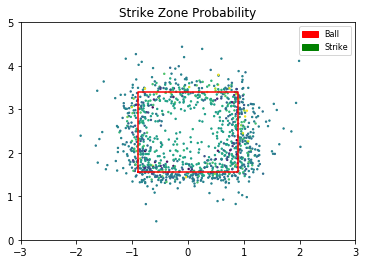

In [21]:
plt.scatter(catcher2.plate_side, catcher2.plate_height, c=list(catcher2['differences']), s=2)
plt.xlim((-3,3))
plt.ylim((0,5))
plt.plot(x,y, 'r-')
plt.legend(handles=[Ball, Strike], prop={'size': 8})
plt.title("Strike Zone Probability")

C:\Users\Trevor\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


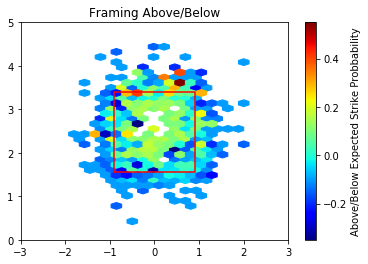

In [22]:
#Heatmaps are an easier way to interpret these kinds of data
plt.title("Framing Above/Below")
plt.subplot(111)
plt.hexbin(catcher2.plate_side, catcher2.plate_height, C=list(catcher2['differences']), gridsize=30, cmap=CM.jet, bins=None)
plt.xlim((-3,3))
plt.ylim((0,5))
cb = plt.colorbar()
plt.plot(x,y, 'r-')
cb.set_label('Above/Below Expected Strike Probbability')
plt.show()   

In [34]:
## This heatmap... Is not great. I probably need to be more specific with what I'm looking for.
#Let's highlight missed strikes and balls
catcher3 = catcher.loc[(catcher['pitch_call'] == 'BallCalled') & (data['Strike_Prob'] > .5)]
catcher4 = catcher.loc[(catcher['pitch_call'] == 'StrikeCalled') & (data['Strike_Prob'] < .5)]
pMapping = {'FA': 'black', 'CH': 'blue', 'SL': 'green', 'CU': 'purple', 'XX' : 'white'}
#And for the coaches, label by pitch type
FA = mpatches.Patch(color='black', label='Fastball')
CH = mpatches.Patch(color='blue',label='Changeup')
SL = mpatches.Patch(color='green', label='Slider')
CU = mpatches.Patch(color='purple',label='Curveball')


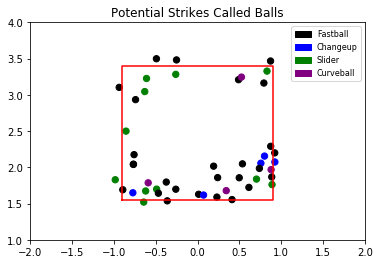

In [32]:
plt.scatter(catcher3.plate_side, catcher3.plate_height, c=list(catcher3['pitch_type'].map(pMapping)), s=40)
plt.xlim((-2,2))
plt.ylim((1,4))
plt.plot(x,y, 'r-')
plt.legend(handles=[FA, CH, SL, CU], prop={'size': 8})
plt.title("Potential Strikes Called Balls")
plt.savefig('misses.png')

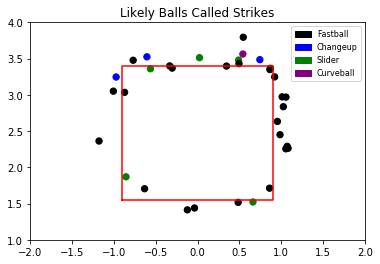

In [33]:
plt.scatter(catcher4.plate_side, catcher4.plate_height, c=list(catcher4['pitch_type'].map(pMapping)), s=40)
plt.xlim((-2,2))
plt.ylim((1,4))
plt.plot(x,y, 'r-')
plt.legend(handles=[FA, CH, SL, CU], prop={'size': 8})
plt.title("Likely Balls Called Strikes")
plt.savefig('hits.png')

In [24]:
##Determine how many total strikes this player missed out on in the prior year
expected = catcher['Strike_Prob'].sum()
actual = sum(list(catcher['pitch_call'].map(sMapping)))
print(f'Our new catcher was expected to get {expected} strikes and actually received {actual}.')

Our new catcher was expected to get 1408.35 strikes and actually received 1368.


In [25]:
expected2 = data['Strike_Prob'].sum()
actual2 = sum(list(data['pitch_call'].map(sMapping)))
print(f'All catchers were expected to get {expected2} strikes and actually received {actual2}.')
##

All catchers were expected to get 96551.40000000001 strikes and actually received 96568.


In [26]:
catcher.pitch_type.unique()

array(['FA', 'CH', 'SL', 'CU', 'XX'], dtype=object)

Text(0.5, 1.0, 'Everything')

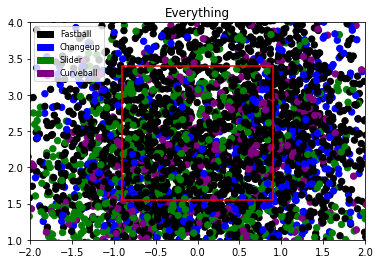

In [27]:
plt.scatter(catcher.plate_side, catcher.plate_height, c=list(catcher['pitch_type'].map(pMapping)), s=40)
plt.xlim((-2,2))
plt.ylim((1,4))
plt.plot(x,y, 'r-')
plt.legend(handles=[FA, CH, SL, CU], prop={'size': 8})
plt.title("Everything")

In [29]:
catcher3.pitch_type.value_counts()

FA    27
SL    11
CH     5
CU     4
Name: pitch_type, dtype: int64

In [30]:
catcher4.pitch_type.value_counts()

FA    25
SL     5
CH     3
CU     1
Name: pitch_type, dtype: int64

In [31]:
catcher.pitch_type.value_counts()

FA    2576
SL     980
CH     692
CU     523
XX       3
Name: pitch_type, dtype: int64

In [45]:
#Note that I iterated through pitch types for this information
#I assumed that in any electronic report sent to the coaches there would be videolinks associated with the pitch IDs

catcher3[catcher.pitch_type == 'FA'].pitch_id.tolist()

C:\Users\Trevor\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


['5b162628',
 'a8e0c199',
 '66c25044',
 '4afa71ca',
 'e8c7d253',
 '4001912f',
 'f3a2b90b',
 'f6b65983',
 'b036cb71',
 'eb95f157',
 '527701c3',
 '2e246d11',
 '572c2268',
 '58dfb60d',
 'ce4893c4',
 'a3d824dc',
 'ba38cdd0',
 '7f9ee721',
 '475892a0',
 '9081bf71',
 'daf7497a',
 'fbd55187',
 '2aa8a5ce',
 '3ed130bf',
 'cb1763a6',
 'ef95a71b',
 'fa7e2a2b']